In [1]:
import torch
import torch.nn as nn
import random
import hashlib
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter
from skimage import exposure
import os
from shutil import copyfile
from torch.utils.data import Dataset



import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


# load data

In [2]:
def load_and_resize_images(model_name, target_size):
    data_folder = "data"
    model_folder = os.path.join(data_folder, model_name)

    if not os.path.exists(model_folder):
        print(f"Error: Model folder '{model_folder}' not found.")
        return None

    image_list = []
    # hashes = set()
    print(len(os.listdir(model_folder)))
    for filename in os.listdir(model_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(model_folder, filename)
            
            # Load the image
            img = cv2.imread(image_path)

            # Resize the image while preserving aspect ratio
            height, width, _ = img.shape
            aspect_ratio = width / height

            # Calculate new dimensions based on the target size
            if aspect_ratio >= 1:
                new_width = target_size
                new_height = int(target_size / aspect_ratio)
            else:
                new_height = target_size
                new_width = int(target_size * aspect_ratio)

            resized_img = cv2.resize(img, (new_width, new_height))
            image_list.append(resized_img)
            # Calculate hash of the resized image
            # img_hash = image_hash(resized_img)

            # # Check for duplicates
            # if img_hash not in hashes:
            #     # Append the resized image to the list
            #     image_list.append(resized_img)
            #     hashes.add(img_hash)

    return image_list

def display_random_images(images, num_images=5):
    num_total_images = len(images)

    if num_images > num_total_images:
        print(f"Error: Requested {num_images} images, but only {num_total_images} available.")
        return

    selected_indices = random.sample(range(num_total_images), num_images)
    selected_images = [images[i] for i in selected_indices]

    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(selected_images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.show()

239


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


images amount: 239


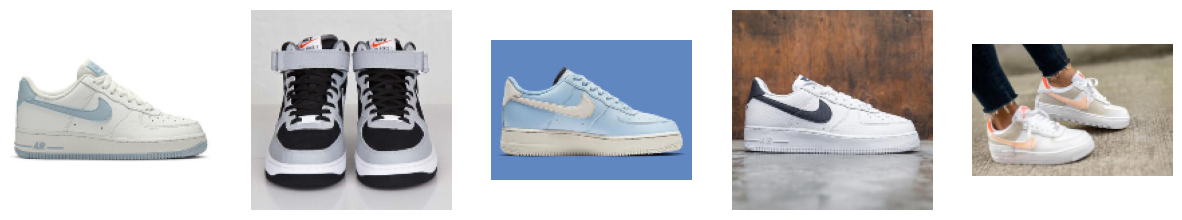

In [3]:
model_name = "Nike Air Forces"
target_size = 150  # Adjust this size as needed
resized_images = load_and_resize_images(model_name, target_size)
print("images amount: " + str(len(resized_images)))

# Display 5 random resized images without duplicates
display_random_images(resized_images, num_images=5)

# cleaning data

In [4]:
def image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

def remove_duplicates(resized_images):
    unique_images = []
    hashes = set()

    for img in resized_images:
        # Calculate hash of the image
        img_hash = image_hash(img)

        # Check for duplicates
        if img_hash not in hashes:
            unique_images.append(img)
            hashes.add(img_hash)

    return unique_images

In [5]:
unique_images = remove_duplicates(resized_images)

# Augmentation

In [6]:
def elastic_deform(image, alpha=200, sigma=20):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = cv2.remap(image, indices[1].astype(np.float32), indices[0].astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT).reshape(shape)

    return distored_image

def color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Adjust brightness
    hsv[:,:,2] = hsv[:,:,2] * (1 + random.uniform(-brightness, brightness))

    # Adjust contrast
    alpha = 1.0 + random.uniform(-contrast, contrast)
    beta = 0.0
    hsv[:,:,2] = cv2.convertScaleAbs(hsv[:,:,2], alpha=alpha, beta=beta)

    # Adjust saturation
    hsv[:,:,1] = hsv[:,:,1] * (1 + random.uniform(-saturation, saturation))

    # Adjust hue
    hsv[:,:,0] = (hsv[:,:,0] + random.uniform(-hue, hue)) % 180

    jittered_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return jittered_image

def salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = image.copy()

    # Salt noise
    num_salt = np.ceil(salt_prob * image.size)
    salt_coords = [np.random.randint(0, high=i, size=int(num_salt)) for i in image.shape]
    noisy_image[tuple(salt_coords)] = 1

    # Pepper noise
    num_pepper = np.ceil(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, high=i, size=int(num_pepper)) for i in image.shape]
    noisy_image[tuple(pepper_coords)] = 0

    return noisy_image

In [7]:
def random_flip(image):
    return cv2.flip(image, random.choice([0, 1]))

def random_rotation(image, max_angle=30):
    angle = random.uniform(-max_angle, max_angle)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.0)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows))

def random_blur(image, max_kernel_size=5):
    kernel_size = random.choice(range(1, max_kernel_size + 1, 2))
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def random_brightness(image, max_alpha=0.3):
    alpha = 1.0 + random.uniform(-max_alpha, max_alpha)
    return np.clip(alpha * image, 0, 255).astype(np.uint8)

def random_color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    return color_jitter(image, brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

def random_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    return salt_and_pepper_noise(image, salt_prob=salt_prob, pepper_prob=pepper_prob)



In [8]:
def augment_dataset(images, num_augmented_per_image=5):
    augmented_dataset = []

    for img in images:
        augmented_dataset.append(img)  # Add the original image

        for _ in range(num_augmented_per_image):
            augmented_img = random_flip(random_rotation(random_blur(random_brightness(random_color_jitter(random_salt_and_pepper_noise(img))))))
            augmented_dataset.append(augmented_img)

    return augmented_dataset

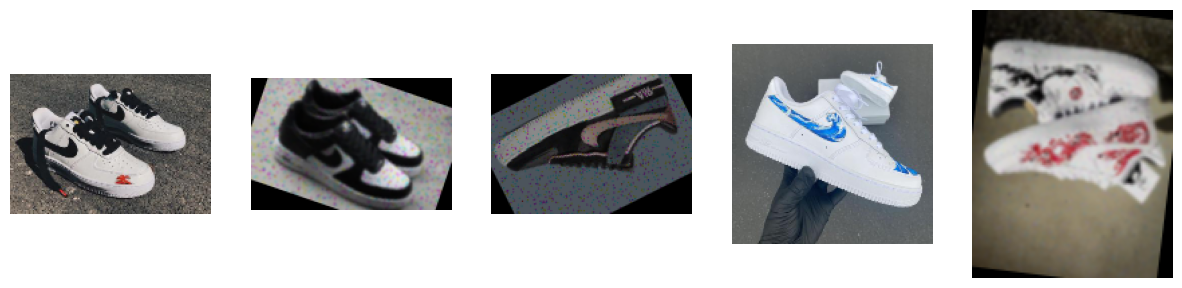

In [9]:
augmented_data = augment_dataset(unique_images)
display_random_images(augmented_data)

In [10]:
import cv2
import os

def save_images(image_list, save_path, prefix='img'):
    """
    Save a list of images to the specified path with a given prefix.
    
    Parameters:
    - image_list (list): List of images (NumPy arrays) to be saved.
    - save_path (str): Directory path where images will be saved.
    - prefix (str, optional): Prefix for the saved image filenames. Default is 'img'.
    """
    os.makedirs(save_path, exist_ok=True)
    
    for i, image in enumerate(image_list):
        filename = f"{prefix}{i + 1}.jpg"
        filepath = os.path.join(save_path, filename)
        cv2.imwrite(filepath, image)

# Example usage:
# Assuming 'image_list' is your list of images (NumPy arrays)
# Assuming 'save_path' is the directory where you want to save the images

save_images(augmented_data, 'augmented_data', prefix='shoe_image_')

# splitting the data

In [12]:
# # Split the data into training (80%), validation (10%), and test (10%) sets
# train_images, test_images, train_labels, test_labels = train_test_split(augmented_data, labels, test_size=0.2, random_state=42)
# val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)